In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [2]:
def random_matrix(shape):
    A = np.random.rand(shape[0], shape[1])*50
    return A

def random_integer_matrix(shape):
    return np.floor(random_matrix(shape))

138.430997671 60.8595704834 (112, 92)


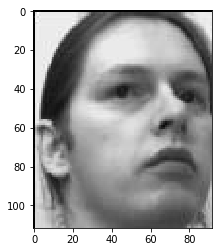

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

im = Image.open("image/umist_cropped.jpg")
data_orig = np.array(im)
# print(data_orig.shape)
# print(np.mean(data_orig), np.std(data_orig))

ws = (112,92)
data = data_orig[ws[0]:2*ws[0],ws[1]:ws[1]*2]
print(np.mean(data), np.std(data), data.shape)
plt.imshow(data, cmap='gray')
plt.show()

In [4]:
#Gibbs
X = data
I = 20
print(np.mean(X), np.std(X))

data_variance = (np.std(X)/I)**2
data_mean = np.mean(X)/I/2.5
#print(data_mean, data_variance)

gamma_scale = data_variance/data_mean # b/sqrt(a) == std
gamma_shape = data_mean/gamma_scale
print(gamma_scale, gamma_shape)

138.430997671 60.8595704834
3.34452487317 0.827806656672


In [5]:
def gibbs(X, gamma_shape, gamma_scale, max_iter):
    W = X.shape[0]
    K = X.shape[1]
    I = 20
    A_t = np.ones((W,I))*gamma_shape
    B_t = np.ones((W,I))*gamma_scale
    A_v = np.ones((I,K))*gamma_shape
    B_v = np.ones((I,K))*gamma_scale
    
    T = np.random.gamma(A_t,B_t)
    V = np.random.gamma(A_v,B_v)

    for n in range(max_iter):

        p = np.zeros((W, I ,K))
        S = np.zeros((W, I ,K))

        for v in range(W):
            for t in range(K):
                p[v, :, t] = ((T[[v],:]*V[:, [t]].T)/ T[[v],:].dot(V[:, [t]]))
                S[v, :, t] = np.random.multinomial(X[v,t], p[v, :, t].squeeze())

        alpha_t = A_t + np.sum(S, axis=2)
        #beta_t = 1./(A_t/B_t + np.ones((W,1)).dot(V.dot(np.ones((K,1))).T))
        beta_t = 1./(B_t + np.ones((W,1)).dot(V.dot(np.ones((K,1))).T));

        alpha_v = A_v + np.sum(S, axis=0)
        #beta_v = 1./(A_v/B_v + np.dot(np.ones((W,1)).T.dot(T).T, np.ones((K,1)).T))
        beta_v = 1./(B_v + np.dot(np.ones((W,1)).T.dot(T).T, np.ones((K,1)).T))

        T = np.random.gamma(alpha_t, beta_t)
        V = np.random.gamma(alpha_v, beta_v)

        if n % 50 == 0:
            mean_diff = np.mean(np.abs(X - np.dot(T,V)))
            print("epoch %d: loss: "%n, mean_diff)
    return T, V

In [6]:
T, V = gibbs(X, gamma_shape, gamma_scale, 400)

epoch 0: loss:  43.1722964981
epoch 50: loss:  13.8194586966
epoch 100: loss:  9.99222756237
epoch 150: loss:  8.847720064
epoch 200: loss:  8.15655793087
epoch 250: loss:  7.66786173822
epoch 300: loss:  7.48770632382
epoch 350: loss:  7.4511610476


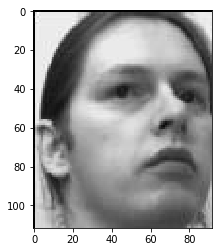

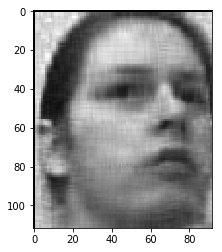

In [7]:
plt.imshow(X, cmap='gray')
plt.show()
plt.imshow(np.dot(T,V), cmap='gray')
plt.show()

In [8]:
print(np.mean(X), np.std(X))
print(np.mean(np.dot(T,V)), np.std(np.dot(T,V)))

138.430997671 60.8595704834
137.642610476 59.7147979705
